# NREL NSRDB GOES Aggregated

Documentation Regarding NSRDB: https://data.openei.org/submissions/1

The following variables are provided by the NSRDB:
- Irradiance:
    - Global Horizontal (ghi)
    - Direct Normal (dni)
    - Diffuse (dhi)
- Clear-sky Irradiance
- Cloud Type
- Dew Point
- Temperature
- Surface Albedo
- Pressure
- Relative Humidity
- Solar Zenith Angle
- Precipitable Water
- Wind Direction
- Wind Speed
- Fill Flag
- Angstrom wavelength exponent (alpha)
- Aerosol optical depth (aod)
- Aerosol asymmetry parameter (asymmetry)
- Cloud optical depth (cld_opd_dcomp)
- Cloud effective radius (cld_ref_dcomp)
- cloud_press_acha
- Reduced ozone vertical pathlength (ozone)
- Aerosol single-scatter albedo (ssa)

Dataset is present as yearly HDF volumes.

The hard part about this dataset is accessing it. It's available to public for free on AWS and Azure, but
the download speeds are too slow.

 - AWS took around 9 minutes to open the dataset (this is just the index, and actual data is not yet fetched)
 - Azure took around 5 minutes for same

Azure is clearly faster but it has less data.

Once dataset is opened there are the above mentioned variables.

Each variable has dimension `(time, location)`

 - `time` has timestamps (for NOAA Aggregated, interval is 30 minutes)

 - `location` has ('latitude', 'longitude', 'elevation', 'timezone', 'country', 'state', 'county', 'urban', 'population', 'landcover')

We can create a subset using the time and location information.




## Accessing Data Via AWS

In [46]:

import h5py
import numpy as np
import fsspec
import xarray as xr

# Path to the file in a public S3 bucket
s3_path = "s3://nrel-pds-nsrdb/GOES/aggregated/v4.0.0/nsrdb_2023.h5"

In [6]:
%%time

f = fsspec.open(s3_path, mode='rb', anon=True).open()    
hdf_file = h5py.File(f, 'r')

CPU times: user 1.26 s, sys: 844 ms, total: 2.1 s
Wall time: 41.6 s


In [9]:
%%time

ds = xr.open_dataset(f, backend_kwargs={"phony_dims": "sort"}, engine="h5netcdf")

CPU times: user 9.36 s, sys: 6.43 s, total: 15.8 s
Wall time: 8min 26s


In [14]:
ds_aws = ds
ds_aws

<xarray.Dataset> Size: 7TB
Dimensions:                   (phony_dim_0: 17520, phony_dim_1: 2018267)
Dimensions without coordinates: phony_dim_0, phony_dim_1
Data variables: (12/28)
    air_temperature           (phony_dim_0, phony_dim_1) float64 283GB ...
    alpha                     (phony_dim_0, phony_dim_1) float64 283GB ...
    aod                       (phony_dim_0, phony_dim_1) float64 283GB ...
    asymmetry                 (phony_dim_0, phony_dim_1) float64 283GB ...
    cld_opd_dcomp             (phony_dim_0, phony_dim_1) float64 283GB ...
    cld_press_acha            (phony_dim_0, phony_dim_1) float64 283GB ...
    ...                        ...
    surface_albedo            (phony_dim_0, phony_dim_1) float64 283GB ...
    surface_pressure          (phony_dim_0, phony_dim_1) float64 283GB ...
    time_index                (phony_dim_0) |S25 438kB ...
    total_precipitable_water  (phony_dim_0, phony_dim_1) float64 283GB ...
    wind_direction            (phony_dim_0, phony_dim_1) float64 283GB ...
    wind_speed                (phony_dim_0, phony_dim_1) float64 283GB ...
Attributes:
    version:  4.0.1

## Accessing Data Via Azure

In [10]:
import xarray as xr
import pandas as pd
import planetary_computer

from adlfs import AzureBlobFileSystem

# Year to investigate and plot
year = 2015

# Storage resources
storage_account_name = 'nrel'
folder = f'nrel-nsrdb/v3'

In [13]:
%%time

fs = AzureBlobFileSystem(
    account_name=storage_account_name,
    credential=planetary_computer.sas.get_token("nrel", "nrel-nsrdb").token
)
file = fs.open(f"nrel-nsrdb/v3/nsrdb_{year}.h5")
ds_azure = xr.open_dataset(file, backend_kwargs={"phony_dims": "sort"}, engine="h5netcdf")
ds_azure

CPU times: user 5.35 s, sys: 3.28 s, total: 8.63 s
Wall time: 4min 29s


<xarray.Dataset> Size: 2TB
Dimensions:                   (phony_dim_0: 17520, phony_dim_1: 2018392,
                               phony_dim_2: 2)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables: (12/28)
    air_temperature           (phony_dim_0, phony_dim_1) int8 35GB ...
    alpha                     (phony_dim_0, phony_dim_1) int16 71GB ...
    aod                       (phony_dim_0, phony_dim_1) int16 71GB ...
    asymmetry                 (phony_dim_0, phony_dim_1) int16 71GB ...
    cld_opd_dcomp             (phony_dim_0, phony_dim_1) int16 71GB ...
    cld_reff_dcomp            (phony_dim_0, phony_dim_1) int16 71GB ...
    ...                        ...
    surface_albedo            (phony_dim_0, phony_dim_1) int16 71GB ...
    surface_pressure          (phony_dim_0, phony_dim_1) int16 71GB ...
    time_index                (phony_dim_0) |S30 526kB ...
    total_precipitable_water  (phony_dim_0, phony_dim_1) int16 71GB ...
    wind_direction            (phony_dim_0, phony_dim_1) int16 71GB ...
    wind_speed                (phony_dim_0, phony_dim_1) int16 71GB ...
Attributes:
    Version:  3.0.6

After opening the datasets (from either AWS or Azure) we can use any one to plot the data.
Let's create a subset of the data of air_temperature over India

In [28]:
# Time dimension 
time_index = pd.to_datetime(ds_aws['time_index'][...].astype(str))
time_index 

DatetimeIndex(['2023-01-01 00:00:00+00:00', '2023-01-01 00:30:00+00:00',
               '2023-01-01 01:00:00+00:00', '2023-01-01 01:30:00+00:00',
               '2023-01-01 02:00:00+00:00', '2023-01-01 02:30:00+00:00',
               '2023-01-01 03:00:00+00:00', '2023-01-01 03:30:00+00:00',
               '2023-01-01 04:00:00+00:00', '2023-01-01 04:30:00+00:00',
               ...
               '2023-12-31 19:00:00+00:00', '2023-12-31 19:30:00+00:00',
               '2023-12-31 20:00:00+00:00', '2023-12-31 20:30:00+00:00',
               '2023-12-31 21:00:00+00:00', '2023-12-31 21:30:00+00:00',
               '2023-12-31 22:00:00+00:00', '2023-12-31 22:30:00+00:00',
               '2023-12-31 23:00:00+00:00', '2023-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17520, freq=None)

In [ ]:
# This is 35360037840 * 8 bytes = 282.88 gigabytes of a single variable!

ds_aws["air_temperature"]

<xarray.DataArray 'air_temperature' (phony_dim_0: 17520, phony_dim_1: 2018267)> Size: 283GB
[35360037840 values with dtype=float64]
Dimensions without coordinates: phony_dim_0, phony_dim_1
Attributes:
    chunks:                  [2000  500]
    data_source:             MERRA2
    elevation_correction:    True
    physical_max:            70.0
    physical_min:            -100.0
    psm_scale_factor:        10.0
    psm_units:               Celsius
    source_dir:              /projects/pxs/ancillary/merra
    spatial_interp_method:   IDW2
    temporal_interp_method:  linear
    units:                   Celsius

In [16]:
ds_aws["meta"]

<xarray.DataArray 'meta' (phony_dim_1: 2018267)> Size: 262MB
[2018267 values with dtype=[('latitude', '<f4'), ('longitude', '<f4'), ('elevation', '<i2'), ('timezone', '<i2'), ('country', 'S36'), ('state', 'S31'), ('county', 'S51')]]
Dimensions without coordinates: phony_dim_1

In [ ]:
# Create a subset of location indexes

meta = ds_aws["meta"].data
df = pd.DataFrame(meta) 

In [ ]:
# Available Countries
df['country'].unique()

array([b'nan', b'Fiji', b'United States', b'Wallis and Futuna',
       b'United States Minor Outlying Islands', b'Tonga', b'Samoa',
       b'Kiribati', b'American Samoa', b'Niue', b'Cook Islands',
       b'French Polynesia', b'Canada', b'Mexico', b'Clipperton Island',
       b'Guatemala', b'Ecuador', b'El Salvador', b'Honduras', b'Belize',
       b'Nicaragua', b'Costa Rica', b'Cuba', b'Panama', b'Colombia',
       b'Cayman Islands', b'Peru', b'Bahamas', b'Jamaica', b'Haiti',
       b'Brazil', b'Venezuela', b'Turks and Caicos Islands',
       b'Dominican Republic', b'Chile', b'Aruba', b'Bolivia',
       b'Cura\xc3\xa7ao', b'Bonaire, Sint Eustatius and Saba',
       b'Puerto Rico', b'Virgin Islands, U.S.', b'Bermuda',
       b'British Virgin Islands', b'Anguilla', b'Saint-Martin',
       b'Sint Maarten', b'Saint Kitts and Nevis',
       b'Saint-Barth\xc3\xa9lemy', b'Paraguay', b'Montserrat',
       b'Trinidad and Tobago', b'Antigua and Barbuda', b'Guadeloupe',
       b'Grenada', b'Domini

In [25]:
# Available states in USA
USA = df[df["country"] == b"United States"]
USA['state'].unique()


array([b'Alaska', b'Hawaii', b'Washington', b'Oregon', b'California',
       b'Nevada', b'Idaho', b'Montana', b'Arizona', b'Utah', b'Wyoming',
       b'Colorado', b'New Mexico', b'Texas', b'North Dakota',
       b'South Dakota', b'Nebraska', b'Oklahoma', b'Kansas', b'Minnesota',
       b'Iowa', b'Missouri', b'Arkansas', b'Louisiana', b'Wisconsin',
       b'Mississippi', b'Illinois', b'Michigan', b'Tennessee',
       b'Kentucky', b'Alabama', b'Indiana', b'Florida', b'Georgia',
       b'Ohio', b'North Carolina', b'Virginia', b'South Carolina',
       b'West Virginia', b'Pennsylvania', b'New York', b'Maryland',
       b'District of Columbia', b'Delaware', b'New Jersey',
       b'Connecticut', b'Massachusetts', b'Vermont', b'New Hampshire',
       b'Rhode Island', b'Maine'], dtype=object)

In [26]:
# Subsetting Wasington
WS = USA[USA["state"] == b'Washington']

WS

,latitude,longitude,elevation,timezone,country,state,county
107904,48.369999,-124.699997,128,-8,b'United States',b'Washington',b'Clallam'
107909,48.169998,-124.699997,50,-8,b'United States',b'Washington',b'Clallam'
107910,48.130001,-124.699997,40,-8,b'United States',b'Washington',b'Clallam'
108227,48.369999,-124.660004,135,-8,b'United States',b'Washington',b'Clallam'
108228,48.330002,-124.660004,36,-8,b'United States',b'Washington',b'Clallam'
...,...,...,...,...,...,...,...
225803,46.049999,-116.980003,709,-8,b'United States',b'Washington',b'Asotin'
225804,46.009998,-116.980003,1065,-8,b'United States',b'Washington',b'Asotin'
226505,46.169998,-116.940002,481,-8,b'United States',b'Washington',b'Asotin'
226508,46.049999,-116.940002,520,-8,b'United States',b'Washington',b'Asotin'


In [33]:
%%time

air_temp_subset = ds_aws["air_temperature"][0, WS.index].load()
air_temp_subset

CPU times: user 13.7 s, sys: 8.17 s, total: 21.9 s
Wall time: 9min 16s


<xarray.DataArray 'air_temperature' (phony_dim_1: 12990)> Size: 104kB
array([740., 770., 760., ..., 330., 370., 310.], shape=(12990,))
Dimensions without coordinates: phony_dim_1
Attributes:
    chunks:                  [2000  500]
    data_source:             MERRA2
    elevation_correction:    True
    physical_max:            70.0
    physical_min:            -100.0
    psm_scale_factor:        10.0
    psm_units:               Celsius
    source_dir:              /projects/pxs/ancillary/merra
    spatial_interp_method:   IDW2
    temporal_interp_method:  linear
    units:                   Celsius

In [59]:
air_temp_subset

<xarray.DataArray 'air_temperature' (phony_dim_1: 12990)> Size: 104kB
array([740., 770., 760., ..., 330., 370., 310.], shape=(12990,))
Dimensions without coordinates: phony_dim_1
Attributes:
    chunks:                  [2000  500]
    data_source:             MERRA2
    elevation_correction:    True
    physical_max:            70.0
    physical_min:            -100.0
    psm_scale_factor:        10.0
    psm_units:               Celsius
    source_dir:              /projects/pxs/ancillary/merra
    spatial_interp_method:   IDW2
    temporal_interp_method:  linear
    units:                   Celsius

In [62]:
# Nice we have a dataset of air temperature over Washington!
# I will be saving it to a local file so I don't have to re-download it every time.
air_temp_subset.to_netcdf("air_temp_washiton2023-01-01T00:00:00.nc")
# the meta data dataframe to a csv file
WS.to_csv("meta_washinton2023-01-01T00:00:00.csv")

/Users/aniket/anaconda3/envs/weather-data-labs/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3579: SerializationWarning: saving variable air_temperature with floating point data as an integer dtype without any _FillValue to use for NaNs
  exec(code_obj, self.user_global_ns, self.user_ns)


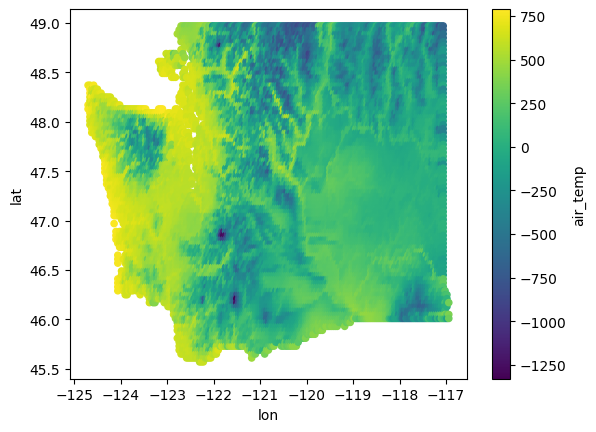

In [ ]:
# Let's plot out the data!

p = pd.DataFrame({"air_temp": air_temp_subset, "lat": WS.latitude, "lon": WS.longitude}).plot.scatter(x="lon", y="lat", c="air_temp", cmap="viridis")

# Converting the data to Zarr

Now we may actually convert this point data to zarr.

For this we need to resample this dataset using `PyResample`.

In [70]:
air_temp_ds = xr.open_dataset("air_temp_washiton2023-01-01T00:00:00.nc")
WS_df = pd.read_csv("meta_washinton2023-01-01T00:00:00.csv")